In [10]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
from typing import Callable
import pandas as pd

In [11]:
# Configuration
DATASET_PATH = "data"
ANNOTATIONS_FILE = os.path.join(DATASET_PATH, "annotations.json")
IMAGES_DIR = os.path.join(DATASET_PATH)
INPUT_SHAPE = (384, 384)  
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_WORKERS = 0

VOC_CLASSES = [
    "background",
    "turtle_head",
    "turtle_carapace",
    "turtle_flipper",
]

VOC_COLORMAP = [
    [128, 0, 128],    # background - purple
    [255, 255, 0],    # head - yellow
    [0, 128, 0],      # Carapace - green
    [0, 0, 255]       # flipper - blue
]

NUM_CLASSES = len(VOC_CLASSES)

# Create necessary directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results', exist_ok=True)

class TurtleSegDataset(Dataset):
    def __init__(self, img_ids, coco, transform=None):
        super().__init__()
        self.img_ids = img_ids
        self.coco = coco
        self.transform = transform
        self.catIds = coco.getCatIds()
        
        print("Pre-computing masks...")
        self.masks = {}
        self.class_counts = {i: np.int64(0) for i in range(NUM_CLASSES)}

        for img_id in tqdm(img_ids, desc="Preprocessing"):
            # Get image info
            img_info = self.get_img_info_by_filename(img_id)
            # print(img_id)
            # print(img_info)
            
            height, width = img_info['height'], img_info['width']
            
            # Create an empty mask
            mask = np.zeros((height, width), dtype=np.uint8)
            mask_id = img_info['id']
            # Get all annotations for this image
            ann_ids = self.coco.getAnnIds(imgIds=mask_id, catIds=self.catIds, iscrowd=None)
            # print(ann_ids)
            # x = input()
            anns = self.coco.loadAnns(ann_ids)
            
            # Define category order for mask application: head > flipper > Carapace
            category_order = [3, 2, 1]  # Apply head first, then flipper, then Carapace
            
            # Apply masks in the specified order
            for cat_id in category_order:
                for ann in anns:
                    if ann['category_id'] == cat_id:
                        single_mask = self.coco.annToMask(ann)
                        # Only update pixels where the mask is currently background (0)
                        mask = np.where((single_mask == 1) & (mask == 0), cat_id, mask)
            
            # Save processed mask
            self.masks[img_id] = mask
            
            # Count pixels per class for weighting
            for class_id in range(NUM_CLASSES):
                self.class_counts[class_id] += np.sum(mask == class_id)
        
        # Calculate class weights based on pixel counts
        total = sum(self.class_counts.values())
        weights = {k: total / (v + 1e-8) for k, v in self.class_counts.items()}
        max_weight = max(weights.values())
        self.class_weights = {k: v / max_weight for k, v in weights.items()}
        print("Class weights:", self.class_weights)
        print("Class counts:", self.class_counts)

    def get_img_info_by_filename(self, file_name):
        # Iterate through the images in the COCO dataset to find a match by file name
        for img_info in self.coco.dataset['images']:
            if img_info['file_name'] == file_name:
                return img_info
        # If not found, raise an error
        raise ValueError(f"Image with file_name '{file_name}' not found in COCO dataset.")

    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        # Get the specific image info using the img_id
        img_info = self.get_img_info_by_filename(img_id)
        
        # Load the image file using the correct file path from img_info
        image = cv2.imread(os.path.join(IMAGES_DIR, img_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get precomputed mask
        mask = self.masks[img_id].copy()
        
        # Resize image and mask to target shape
        image = cv2.resize(image, INPUT_SHAPE)
        mask = cv2.resize(mask, INPUT_SHAPE, interpolation=cv2.INTER_NEAREST)
        
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask

class FCNTurtle(nn.Module):
    def __init__(self, num_classes):
        super(FCNTurtle, self).__init__()
        
   
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
    
        self.features = []
        for name, module in backbone.named_children():
            if name not in ['avgpool', 'fc']:
                self.features.append(module)
        self.features = nn.ModuleList(self.features)
        
    
        print("Freezing backbone parameters...")
        for param in self.features.parameters():
            param.requires_grad = False
        
   
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(2048, 1024, 1),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(1024, 512, 1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(512, 256, 1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(256, num_classes, 1)
            )
        ])
        

        self.attention = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(ch, ch//16, 1),
                nn.ReLU(inplace=True),
                nn.Conv2d(ch//16, ch, 1),
                nn.Sigmoid()
            ) for ch in [2048, 1024, 512, 256]
        ])
        
        self._initialize_decoder_weights()
        self._print_trainable_parameters()
    
    def _initialize_decoder_weights(self):
        for m in self.decoder.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        for m in self.attention.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def _print_trainable_parameters(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Total parameters: {total_params:,}')
        print(f'Trainable parameters: {trainable_params:,}')
        print(f'Frozen parameters: {total_params - trainable_params:,}')
    
    def forward(self, x):
        skips = []
        
        with torch.no_grad():
            for i, feature in enumerate(self.features):
                x = feature(x)
                if i in [4, 5, 6, 7]:
                    skips.append(x.detach())
        
        for i, (decoder, attention) in enumerate(zip(self.decoder, self.attention)):
            att = attention(x)
            x = x * att
            x = decoder(x)
            
            if i < len(skips) - 1:
                x = F.interpolate(x, size=skips[-i-2].shape[2:], mode='bilinear', align_corners=True)
                x = x + skips[-i-2]
        
        x = F.interpolate(x, size=INPUT_SHAPE, mode='bilinear', align_corners=True)
        return x

def get_training_augmentation():
    return A.Compose([
        A.RandomResizedCrop(
            height=INPUT_SHAPE[0],
            width=INPUT_SHAPE[1],
            scale=(0.7, 1.0),
            ratio=(0.8, 1.2)
        ),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=45,
            p=0.8
        ),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.8),
            A.RandomGamma(p=0.8),
        ], p=0.5),
        A.OneOf([
            A.ElasticTransform(
                alpha=120,
                sigma=120 * 0.05,
                p=1.0
            ),
            A.GridDistortion(p=1.0),
            A.OpticalDistortion(
                distort_limit=2,
                shift_limit=0.5,
                p=1.0
            ),
        ], p=0.3),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ])

def get_validation_augmentation():
    return A.Compose([
        A.Resize(
            height=INPUT_SHAPE[0],
            width=INPUT_SHAPE[1]
        ),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ])

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class SimpleBoundaryLoss(nn.Module):
    def __init__(self):
        super(SimpleBoundaryLoss, self).__init__()
        self.criterion = nn.MSELoss()
    
    def forward(self, inputs, targets):
        B, C, H, W = inputs.shape
        pred_probs = F.softmax(inputs, dim=1)
        target_one_hot = F.one_hot(targets, num_classes=C).permute(0, 3, 1, 2).float()
        
        pred_dx = torch.abs(pred_probs[:, :, :, 1:] - pred_probs[:, :, :, :-1])
        pred_dy = torch.abs(pred_probs[:, :, 1:, :] - pred_probs[:, :, :-1, :])
        
        target_dx = torch.abs(target_one_hot[:, :, :, 1:] - target_one_hot[:, :, :, :-1])
        target_dy = torch.abs(target_one_hot[:, :, 1:, :] - target_one_hot[:, :, :-1, :])
        
        loss_dx = self.criterion(pred_dx, target_dx)
        loss_dy = self.criterion(pred_dy, target_dy)
        
        return loss_dx + loss_dy

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.4):
        super(CombinedLoss, self).__init__()
        weights = torch.tensor([1.0, 2.0, 100.0, 100.0])  
        self.ce = nn.CrossEntropyLoss(weight=weights)
        self.dice = DiceLoss()
        self.boundary = SimpleBoundaryLoss()
        self.alpha = alpha

    def to(self, device):
        # Move all components to the specified device
        self.ce.weight = self.ce.weight.to(device)
        self.dice = self.dice.to(device)
        self.boundary = self.boundary.to(device)
        return self
    
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        boundary_loss = self.boundary(inputs, targets)
        return self.alpha * ce_loss + 0.4 * dice_loss + 0.2 * boundary_loss


def visualize_predictions(model, loader, num_samples=3, save_path='results/predictions.png', device='cpu'):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(loader):
            if idx >= num_samples:
                break
            
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)[0].cpu().numpy()
            
            # Prepare the original image for display and clip values for valid range
            image = images[0].cpu().numpy().transpose(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1] for display
            image = np.clip(image, 0, 1)  # Clip to valid range for imshow
            
            # Generate colored masks
            true_mask = masks[0].cpu().numpy()
            true_mask_colored = np.zeros((*true_mask.shape, 3), dtype=np.uint8)
            pred_mask_colored = np.zeros((*preds.shape, 3), dtype=np.uint8)
            
            for class_id, color in color_map.items():
                true_mask_colored[true_mask == class_id] = color
                pred_mask_colored[preds == class_id] = color
            
            class_percentages = []
            for i in range(NUM_CLASSES):
                percent = np.sum(preds == i) / preds.size * 100
                class_percentages.append(f"{VOC_CLASSES[i]}: {percent:.1f}%")
            
            # Display images and masks
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(true_mask_colored)
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(pred_mask_colored)
            axes[idx, 2].set_title('Prediction\n' + '\n'.join(class_percentages))
            axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    class_intersections = np.zeros(NUM_CLASSES)
    class_unions = np.zeros(NUM_CLASSES)

    with torch.no_grad():
        for images, masks in loader:
            # Move images and masks to the device
            images = images.to(device).float()
            masks = masks.to(device).long()
            
            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()
            
            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (masks == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                class_intersections[class_id] += intersection
                class_unions[class_id] += union

    class_ious = class_intersections / (class_unions + 1e-7)
    mean_iou = np.mean(class_ious)
    avg_loss = total_loss / len(loader)

    return {
        "loss": avg_loss,
        "class_iou": class_ious,
        "mean_iou": mean_iou
    }



def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=EPOCHS, device='cpu'):
    best_iou = 0.0
    patience = 7
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'class_ious': [], 'best_epoch': 0}

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        batch_metrics = {i: [] for i in range(NUM_CLASSES)}

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks in pbar:
            # Move images and masks to the device
            images = images.to(device).float()
            masks = masks.to(device).long()
            
            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)  # Calculate loss
            
            loss.backward()  # Backpropagation
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()  # Update weights
            
            if scheduler is not None:
                scheduler.step()

            epoch_loss += loss.item()
            
            # Calculate batch metrics
            with torch.no_grad():
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                masks_np = masks.cpu().numpy()
                for class_id in range(NUM_CLASSES):
                    for pred, true in zip(preds, masks_np):
                        intersection = np.logical_and(pred == class_id, true == class_id).sum()
                        union = np.logical_or(pred == class_id, true == class_id).sum()
                        iou = intersection / (union + 1e-7)
                        batch_metrics[class_id].append(iou)
            
            # Update progress bar
            mean_ious = {VOC_CLASSES[i]: f'{np.mean(batch_metrics[i][-10:]):.3f}' 
                       for i in range(NUM_CLASSES)}
            current_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lr': f'{current_lr:.6f}',
                **mean_ious
            })

        # Validation phase
        val_metrics = evaluate_model(model, val_loader, criterion, device)

        # Save history
        history['train_loss'].append(epoch_loss / len(train_loader))
        history['val_loss'].append(val_metrics["loss"])
        history['class_ious'].append(val_metrics["class_iou"])

        # Print epoch results
        print(f'\nEpoch {epoch + 1} Results:')
        print(f'Train Loss: {epoch_loss / len(train_loader):.4f}')
        print(f'Val Loss: {val_metrics["loss"]:.4f}')
        print(f'Mean IoU: {val_metrics["mean_iou"]:.4f}')
        print('\nPer-class IoU:')
        for i in range(NUM_CLASSES):
            print(f'{VOC_CLASSES[i]}: {val_metrics["class_iou"][i]:.4f}')

        # Save best model
        if val_metrics["mean_iou"] > best_iou:
            best_iou = val_metrics["mean_iou"]
            history['best_epoch'] = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_iou': best_iou,
            }, 'checkpoints/best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs')
            break

        # Save visualization
        if (epoch + 1) % 5 == 0:
            visualize_predictions(model, val_loader, save_path=f'results/epoch_{epoch+1}.png', device=device)

    return model, history



def plot_training_history(history):
    plt.figure(figsize=(20, 5))
    
    # Plot losses
    plt.subplot(131)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot class IoUs
    plt.subplot(132)
    class_ious = np.array(history['class_ious'])
    for i in range(NUM_CLASSES):
        plt.plot(class_ious[:, i], label=VOC_CLASSES[i])
    plt.title('Class-wise IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    # Plot mean IoU
    plt.subplot(133)
    mean_ious = class_ious.mean(axis=1)
    plt.plot(mean_ious, label='Mean IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300)
    plt.close()

def visualize_sample_predictions(model, test_loader, num_samples=6, device='cpu'):
    model.eval()
    
    # Set up subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16)
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    metrics_per_image = []
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            if idx >= num_samples:
                break
            
            # Move images to the device
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)[0].cpu().numpy()
            
            # Retrieve the original mask and calculate IoU for each class
            mask = masks[0].numpy()
            ious = []
            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (mask == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                iou = intersection / (union + 1e-7)
                ious.append(iou)
            
            # Prepare the original image for display and clip to [0, 1] for float
            image = images[0].cpu().numpy().transpose(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            image = np.clip(image, 0, 1)  # Clip to [0, 1] to ensure valid display range
            
            # Create colored true and predicted masks
            true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
            pred_mask_colored = np.zeros((*preds.shape, 3), dtype=np.float32)
            for class_id, color in color_map.items():
                true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
                pred_mask_colored[preds == class_id] = np.array(color) / 255.0
            
            # Display images and metrics
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(true_mask_colored)
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(pred_mask_colored)
            title = f'Prediction\n' + \
                    f'Background IoU: {ious[0]:.3f}\n' + \
                    f'Head IoU: {ious[1]:.3f}\n' + \
                    f'Carapace IoU: {ious[2]:.3f}\n' + \
                    f'Flipper IoU: {ious[3]:.3f}'
            axes[idx, 2].set_title(title)
            axes[idx, 2].axis('off')
            
            metrics_per_image.append({
                'Background IoU': ious[0],
                'Head IoU': ious[1],
                'Carapace IoU': ious[2],
                'Flipper IoU': ious[3],
                'Mean IoU': np.mean(ious)
            })
    
    plt.tight_layout()
    plt.show()
    
    # Display and return per-image metrics as a DataFrame
    metrics_df = pd.DataFrame(metrics_per_image)
    print("\nPer-image Segmentation Metrics:")
    print(metrics_df.round(3))
    
    mean_metrics = metrics_df.mean()
    print("\nAverage Metrics:")
    print(mean_metrics.round(3))
    
    return metrics_df

def plot_training_history(history):
    """
    Plot training history including training and validation loss, mean IoU, and class-specific IoUs.
    
    Parameters:
    - history: Dictionary with keys 'train_loss', 'val_loss', 'class_ious' which contains training history.
    """
    epochs = len(history['train_loss'])
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # 1. Plot Training and Validation Loss
    axes[0].plot(range(epochs), history['train_loss'], label='Train Loss', color='blue')
    axes[0].plot(range(epochs), history['val_loss'], label='Validation Loss', color='orange', linestyle="--")
    axes[0].set_title("Training Metrics")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # 2. Plot Mean IoU for Training and Validation
    val_mean_ious = [np.mean(epoch_iou) for epoch_iou in history['class_ious']]
    axes[1].plot(range(epochs), val_mean_ious, label='Validation Mean IoU', color='orange', linestyle="--")
    axes[1].set_title("Validation Metrics")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Mean IoU")
    axes[1].legend()

    # 3. Plot Class-specific IoUs for Training and Validation
    class_ious = np.array(history['class_ious'])
    for i, class_name in enumerate(VOC_CLASSES):
        axes[2].plot(range(epochs), class_ious[:, i], label=f"{class_name}", linestyle="-")
    
    axes[2].set_title("Class IoU Metrics")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("IoU")
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300)
    plt.show()

def visualize_best_predictions(model, test_loader, device='cpu'):
    model.eval()
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    images_list = []
    masks_list = []
    preds_list = []
    metrics_list = []
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.numpy()
            images_cpu = images.cpu().numpy()
            
            batch_size = images.shape[0]
            
            for i in range(batch_size):
                image = images_cpu[i]
                pred = preds[i]
                mask = masks[i]
                
                # Compute IoU per class
                ious = []
                for class_id in range(NUM_CLASSES):
                    pred_mask = (pred == class_id)
                    true_mask = (mask == class_id)
                    intersection = np.logical_and(pred_mask, true_mask).sum()
                    union = np.logical_or(pred_mask, true_mask).sum()
                    iou = intersection / (union + 1e-7)
                    ious.append(iou)
                mean_iou = np.mean(ious)
                
                # Append data
                images_list.append(image)
                masks_list.append(mask)
                preds_list.append(pred)
                metrics_list.append({
                    'Background IoU': ious[0],
                    'Head IoU': ious[1],
                    'Carapace IoU': ious[2],
                    'Flipper IoU': ious[3],
                    'Mean IoU': mean_iou
                })
        
    # Create DataFrame and sort by Mean IoU
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df_sorted = metrics_df.sort_values(by='Mean IoU')
    
    # Get indices of best images
    best_indices = metrics_df_sorted.index[-3:].tolist()
    
    selected_indices =  best_indices
    
    # Set up subplots using GridSpec
    num_samples = 6
    fig = plt.figure(figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16, y=0.99)
    
    gs = plt.GridSpec(num_samples, 3, figure=fig)
    
    # Add labels for worst and best results
    fig.text(0.5, 0.94, 'Best Segmentation Results', ha='center', fontsize=18)
    
    for idx, index in enumerate(selected_indices):
        image = images_list[index]
        mask = masks_list[index]
        pred = preds_list[index]
        ious = metrics_df.iloc[index][['Background IoU', 'Head IoU', 'Carapace IoU', 'Flipper IoU']].values
        
        row = idx
        col = 0
        ax0 = fig.add_subplot(gs[row, col])
        ax1 = fig.add_subplot(gs[row, col + 1])
        ax2 = fig.add_subplot(gs[row, col + 2])
        
        # Prepare the original image for display and clip to [0, 1] for float
        image_disp = image.transpose(1, 2, 0)
        image_disp = (image_disp - image_disp.min()) / (image_disp.max() - image_disp.min())  # Normalize to [0, 1]
        image_disp = np.clip(image_disp, 0, 1)  # Clip to [0, 1] to ensure valid display range
        
        # Create colored true and predicted masks
        true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
        pred_mask_colored = np.zeros((*pred.shape, 3), dtype=np.float32)
        for class_id, color in color_map.items():
            true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
            pred_mask_colored[pred == class_id] = np.array(color) / 255.0
        
        # Display images and metrics
        ax0.imshow(image_disp)
        ax0.set_title('Original Image')
        ax0.axis('off')
        
        ax1.imshow(true_mask_colored)
        ax1.set_title('Ground Truth')
        ax1.axis('off')
        
        ax2.imshow(pred_mask_colored)
        title = f'Prediction\n' + \
                f'Background IoU: {ious[0]:.3f}\n' + \
                f'Head IoU: {ious[1]:.3f}\n' + \
                f'Carapace IoU: {ious[2]:.3f}\n' + \
                f'Flipper IoU: {ious[3]:.3f}\n' + \
                f'Mean IoU: {np.mean(ious):.3f}'
        ax2.set_title(title)
        ax2.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to make room for the labels
    plt.show()
    
    
    return metrics_df


def visualize_worst_predictions(model, test_loader, device='cpu'):
    model.eval()
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    images_list = []
    masks_list = []
    preds_list = []
    metrics_list = []
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.numpy()
            images_cpu = images.cpu().numpy()
            
            batch_size = images.shape[0]
            
            for i in range(batch_size):
                image = images_cpu[i]
                pred = preds[i]
                mask = masks[i]
                
                # Compute IoU per class
                ious = []
                for class_id in range(NUM_CLASSES):
                    pred_mask = (pred == class_id)
                    true_mask = (mask == class_id)
                    intersection = np.logical_and(pred_mask, true_mask).sum()
                    union = np.logical_or(pred_mask, true_mask).sum()
                    iou = intersection / (union + 1e-7)
                    ious.append(iou)
                mean_iou = np.mean(ious)
                
                # Append data
                images_list.append(image)
                masks_list.append(mask)
                preds_list.append(pred)
                metrics_list.append({
                    'Background IoU': ious[0],
                    'Head IoU': ious[1],
                    'Carapace IoU': ious[2],
                    'Flipper IoU': ious[3],
                    'Mean IoU': mean_iou
                })
        
    # Create DataFrame and sort by Mean IoU
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df_sorted = metrics_df.sort_values(by='Mean IoU')
    
    # Get indices of worst images
    worst_indices = metrics_df_sorted.index[:3].tolist()
    
    selected_indices = worst_indices
    
    # Set up subplots using GridSpec
    num_samples = 3
    fig = plt.figure(figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16, y=0.99)
    
    gs = plt.GridSpec(num_samples, 3, figure=fig)
    
    # Add labels for worst and best results
    fig.text(0.5, 0.94, 'Worst Segmentation Results', ha='center', fontsize=18)
    
    for idx, index in enumerate(selected_indices):
        image = images_list[index]
        mask = masks_list[index]
        pred = preds_list[index]
        ious = metrics_df.iloc[index][['Background IoU', 'Head IoU', 'Carapace IoU', 'Flipper IoU']].values
        
        row = idx
        col = 0
        ax0 = fig.add_subplot(gs[row, col])
        ax1 = fig.add_subplot(gs[row, col + 1])
        ax2 = fig.add_subplot(gs[row, col + 2])
        
        # Prepare the original image for display and clip to [0, 1] for float
        image_disp = image.transpose(1, 2, 0)
        image_disp = (image_disp - image_disp.min()) / (image_disp.max() - image_disp.min())  # Normalize to [0, 1]
        image_disp = np.clip(image_disp, 0, 1)  # Clip to [0, 1] to ensure valid display range
        
        # Create colored true and predicted masks
        true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
        pred_mask_colored = np.zeros((*pred.shape, 3), dtype=np.float32)
        for class_id, color in color_map.items():
            true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
            pred_mask_colored[pred == class_id] = np.array(color) / 255.0
        
        # Display images and metrics
        ax0.imshow(image_disp)
        ax0.set_title('Original Image')
        ax0.axis('off')
        
        ax1.imshow(true_mask_colored)
        ax1.set_title('Ground Truth')
        ax1.axis('off')
        
        ax2.imshow(pred_mask_colored)
        title = f'Prediction\n' + \
                f'Background IoU: {ious[0]:.3f}\n' + \
                f'Head IoU: {ious[1]:.3f}\n' + \
                f'Carapace IoU: {ious[2]:.3f}\n' + \
                f'Flipper IoU: {ious[3]:.3f}\n' + \
                f'Mean IoU: {np.mean(ious):.3f}'
        ax2.set_title(title)
        ax2.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to make room for the labels
    plt.show()
    
    
    return metrics_df

In [12]:

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Load COCO dataset
print("Loading COCO dataset...")
coco = COCO(ANNOTATIONS_FILE)

# Map image IDs to file names
image_id_to_filename = {img['id']: img['file_name'] for img in coco.dataset['images']}

# Create annotations_dict mapping image file names to their annotations
annotations_dict = {}
for annotation in coco.loadAnns(coco.getAnnIds()):
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        image_file_name = image_id_to_filename[image_id]
        annotations_dict.setdefault(image_file_name, []).append(annotation)
    else:
        print(f"Warning: image_id {image_id} in annotations does not have a corresponding image.")

# Display basic information about annotations
if annotations_dict:
    print(f"Number of unique images with annotations: {len(annotations_dict)}")
else:
    print("No annotations found in dataset.")

# Find images that have no annotations
images_without_annotations = [
    file_name for file_name in image_id_to_filename.values()
    if file_name not in annotations_dict
]
print(f"\nNumber of images without annotations: {len(images_without_annotations)}")

# Load metadata CSV for dataset splits
metadata_file = 'data/metadata_splits.csv'
metadata_df = pd.read_csv(metadata_file)

# Column specifying split type
split_column = 'split_open'

# Image IDs with incorrect annotations to exclude
bad_image_ids = [7772, 8436, 1958, 4566, 6730, 6732, 6733, 6735, 7187, 3975, 3793, 1880, 3739, 5950, 6728, 6729, 6731, 6734, 6736, 6936]

# Create dataset splits based on CSV and exclude bad annotations
train_df = metadata_df[(metadata_df[split_column] == 'train') & (~metadata_df['id'].isin(bad_image_ids))]
valid_df = metadata_df[(metadata_df[split_column] == 'valid') & (~metadata_df['id'].isin(bad_image_ids))]
test_df = metadata_df[(metadata_df[split_column] == 'test') & (~metadata_df['id'].isin(bad_image_ids))]

# Ensure only images with annotations are included in each split
train_image_paths = [img for img in train_df['file_name'] if img in annotations_dict]
valid_image_paths = [img for img in valid_df['file_name'] if img in annotations_dict]
test_image_paths = [img for img in test_df['file_name'] if img in annotations_dict]

# Filter annotation dictionaries for each split
train_annotations = {k: annotations_dict[k] for k in train_image_paths}
valid_annotations = {k: annotations_dict[k] for k in valid_image_paths}
test_annotations = {k: annotations_dict[k] for k in test_image_paths}

# Print dataset split summaries
print(f"Training set contains {len(train_annotations)} images.")
print(f"Validation set contains {len(valid_annotations)} images.")
print(f"Test set contains {len(test_annotations)} images.")

# Create datasets and data loaders
print("\nCreating datasets...")
# Update dataset initializations
train_dataset = TurtleSegDataset(train_image_paths, coco, transform=get_training_augmentation())
val_dataset = TurtleSegDataset(valid_image_paths, coco, transform=get_validation_augmentation())
test_dataset = TurtleSegDataset(test_image_paths, coco, transform=get_validation_augmentation())



# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

Using device: cuda
Loading COCO dataset...
loading annotations into memory...
Done (t=3.46s)
creating index...
index created!
Number of unique images with annotations: 8726

Number of images without annotations: 3
Training set contains 5293 images.
Validation set contains 1117 images.
Test set contains 2299 images.

Creating datasets...
Pre-computing masks...


Preprocessing: 100%|██████████| 5293/5293 [04:10<00:00, 21.13it/s]


Class weights: {0: 0.02390477737201429, 1: 0.2123554047448123, 2: 0.6252280622500225, 3: 1.0}
Class counts: {0: 12118789834, 1: 1364208146, 2: 463346082, 3: 289696973}
Pre-computing masks...


Preprocessing: 100%|██████████| 1117/1117 [00:57<00:00, 19.48it/s]


Class weights: {0: 0.02108905947484683, 1: 0.2447460236698178, 2: 0.585259134224602, 3: 1.0}
Class counts: {0: 2601845524, 1: 224193530, 2: 93754154, 3: 54870475}
Pre-computing masks...


Preprocessing: 100%|██████████| 2299/2299 [01:58<00:00, 19.43it/s]

Class weights: {0: 0.020620337198701145, 1: 0.22758217742959932, 2: 0.5936412562812249, 3: 1.0}
Class counts: {0: 5350832236, 1: 484818127, 2: 185863034, 3: 110335965}


In [13]:
# Create model and move it to device
print("\nCreating model...")
model = FCNTurtle(num_classes=NUM_CLASSES).to(device)

# Only get trainable parameters
trainable_params = [
    {'params': model.decoder.parameters()},
    {'params': model.attention.parameters()}
]

# Create optimizer
optimizer = torch.optim.AdamW(
    trainable_params,
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# Create scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=2,
    eta_min=1e-6
)

# Create loss function and move to device
criterion = CombinedLoss(alpha=0.4).to(device)

# Train model
print("\nStarting training...")
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=EPOCHS,
    device=device  # Pass device
)


Creating model...
Freezing backbone parameters...
Total parameters: 26,967,348
Trainable parameters: 3,459,316
Frozen parameters: 23,508,032

Starting training...


Epoch 1/20: 100%|██████████| 1324/1324 [04:14<00:00,  5.20it/s, loss=1.1928, lr=0.000100, background=0.812, turtle_head=0.290, turtle_carapace=0.190, turtle_flipper=0.180]



Epoch 1 Results:
Train Loss: 1.2734
Val Loss: 1.0623
Mean IoU: 0.3778

Per-class IoU:
background: 0.7652
turtle_head: 0.3549
turtle_carapace: 0.1464
turtle_flipper: 0.2445


Epoch 2/20: 100%|██████████| 1324/1324 [03:39<00:00,  6.03it/s, loss=0.3071, lr=0.000100, background=0.871, turtle_head=0.338, turtle_carapace=0.154, turtle_flipper=0.172]



Epoch 2 Results:
Train Loss: 0.7381
Val Loss: 0.8418
Mean IoU: 0.4250

Per-class IoU:
background: 0.7949
turtle_head: 0.4347
turtle_carapace: 0.1691
turtle_flipper: 0.3015


Epoch 3/20: 100%|██████████| 1324/1324 [03:42<00:00,  5.96it/s, loss=0.4799, lr=0.000042, background=0.912, turtle_head=0.520, turtle_carapace=0.317, turtle_flipper=0.332]



Epoch 3 Results:
Train Loss: 0.5982
Val Loss: 0.4906
Mean IoU: 0.5131

Per-class IoU:
background: 0.8646
turtle_head: 0.5422
turtle_carapace: 0.2333
turtle_flipper: 0.4124


Epoch 4/20: 100%|██████████| 1324/1324 [03:45<00:00,  5.88it/s, loss=0.1757, lr=0.000100, background=0.826, turtle_head=0.497, turtle_carapace=0.354, turtle_flipper=0.273]



Epoch 4 Results:
Train Loss: 0.5290
Val Loss: 0.7131
Mean IoU: 0.4550

Per-class IoU:
background: 0.8366
turtle_head: 0.5025
turtle_carapace: 0.2075
turtle_flipper: 0.2732


Epoch 5/20: 100%|██████████| 1324/1324 [03:56<00:00,  5.60it/s, loss=0.1740, lr=0.000080, background=0.917, turtle_head=0.680, turtle_carapace=0.334, turtle_flipper=0.492]



Epoch 5 Results:
Train Loss: 0.4662
Val Loss: 0.4151
Mean IoU: 0.5265

Per-class IoU:
background: 0.8687
turtle_head: 0.5505
turtle_carapace: 0.2418
turtle_flipper: 0.4449


Epoch 6/20: 100%|██████████| 1324/1324 [03:55<00:00,  5.61it/s, loss=1.6429, lr=0.000042, background=0.933, turtle_head=0.475, turtle_carapace=0.259, turtle_flipper=0.394]



Epoch 6 Results:
Train Loss: 0.4057
Val Loss: 0.3359
Mean IoU: 0.5672

Per-class IoU:
background: 0.8893
turtle_head: 0.5886
turtle_carapace: 0.2795
turtle_flipper: 0.5114


Epoch 7/20: 100%|██████████| 1324/1324 [03:52<00:00,  5.69it/s, loss=0.4123, lr=0.000009, background=0.927, turtle_head=0.620, turtle_carapace=0.374, turtle_flipper=0.368]



Epoch 7 Results:
Train Loss: 0.3750
Val Loss: 0.4297
Mean IoU: 0.5171

Per-class IoU:
background: 0.8599
turtle_head: 0.5534
turtle_carapace: 0.2272
turtle_flipper: 0.4278


Epoch 8/20: 100%|██████████| 1324/1324 [03:45<00:00,  5.87it/s, loss=0.1069, lr=0.000100, background=0.939, turtle_head=0.510, turtle_carapace=0.248, turtle_flipper=0.348]



Epoch 8 Results:
Train Loss: 0.3714
Val Loss: 0.2883
Mean IoU: 0.5926

Per-class IoU:
background: 0.9132
turtle_head: 0.5998
turtle_carapace: 0.3057
turtle_flipper: 0.5518


Epoch 9/20: 100%|██████████| 1324/1324 [03:37<00:00,  6.10it/s, loss=0.4924, lr=0.000094, background=0.900, turtle_head=0.514, turtle_carapace=0.314, turtle_flipper=0.386]



Epoch 9 Results:
Train Loss: 0.3438
Val Loss: 0.2524
Mean IoU: 0.6339

Per-class IoU:
background: 0.9285
turtle_head: 0.6651
turtle_carapace: 0.3720
turtle_flipper: 0.5701


Epoch 10/20: 100%|██████████| 1324/1324 [04:22<00:00,  5.04it/s, loss=0.7628, lr=0.000080, background=0.926, turtle_head=0.574, turtle_carapace=0.349, turtle_flipper=0.498]



Epoch 10 Results:
Train Loss: 0.3151
Val Loss: 0.3522
Mean IoU: 0.5428

Per-class IoU:
background: 0.8549
turtle_head: 0.5661
turtle_carapace: 0.2312
turtle_flipper: 0.5192


Epoch 11/20: 100%|██████████| 1324/1324 [04:31<00:00,  4.88it/s, loss=0.3465, lr=0.000062, background=0.907, turtle_head=0.456, turtle_carapace=0.248, turtle_flipper=0.388]



Epoch 11 Results:
Train Loss: 0.2946
Val Loss: 0.2561
Mean IoU: 0.5920

Per-class IoU:
background: 0.8950
turtle_head: 0.6145
turtle_carapace: 0.2985
turtle_flipper: 0.5599


Epoch 12/20: 100%|██████████| 1324/1324 [03:40<00:00,  5.99it/s, loss=0.2247, lr=0.000042, background=0.956, turtle_head=0.630, turtle_carapace=0.421, turtle_flipper=0.486]



Epoch 12 Results:
Train Loss: 0.2726
Val Loss: 0.2276
Mean IoU: 0.6354

Per-class IoU:
background: 0.9206
turtle_head: 0.6548
turtle_carapace: 0.3568
turtle_flipper: 0.6093


Epoch 13/20: 100%|██████████| 1324/1324 [03:36<00:00,  6.12it/s, loss=0.3851, lr=0.000024, background=0.939, turtle_head=0.625, turtle_carapace=0.396, turtle_flipper=0.598]



Epoch 13 Results:
Train Loss: 0.2677
Val Loss: 0.3090
Mean IoU: 0.5831

Per-class IoU:
background: 0.8829
turtle_head: 0.6047
turtle_carapace: 0.2792
turtle_flipper: 0.5656


Epoch 14/20: 100%|██████████| 1324/1324 [03:33<00:00,  6.21it/s, loss=0.3869, lr=0.000010, background=0.858, turtle_head=0.572, turtle_carapace=0.387, turtle_flipper=0.491]



Epoch 14 Results:
Train Loss: 0.2626
Val Loss: 0.2335
Mean IoU: 0.6534

Per-class IoU:
background: 0.9269
turtle_head: 0.6964
turtle_carapace: 0.3571
turtle_flipper: 0.6331


Epoch 15/20: 100%|██████████| 1324/1324 [03:34<00:00,  6.18it/s, loss=0.5932, lr=0.000002, background=0.909, turtle_head=0.500, turtle_carapace=0.257, turtle_flipper=0.460]



Epoch 15 Results:
Train Loss: 0.2615
Val Loss: 0.2869
Mean IoU: 0.6019

Per-class IoU:
background: 0.8938
turtle_head: 0.5725
turtle_carapace: 0.3352
turtle_flipper: 0.6060


Epoch 16/20: 100%|██████████| 1324/1324 [03:40<00:00,  6.01it/s, loss=0.3000, lr=0.000100, background=0.915, turtle_head=0.646, turtle_carapace=0.432, turtle_flipper=0.604]



Epoch 16 Results:
Train Loss: 0.2594
Val Loss: 0.2949
Mean IoU: 0.6150

Per-class IoU:
background: 0.9083
turtle_head: 0.6720
turtle_carapace: 0.2958
turtle_flipper: 0.5837


Epoch 17/20: 100%|██████████| 1324/1324 [03:33<00:00,  6.20it/s, loss=0.3732, lr=0.000098, background=0.940, turtle_head=0.704, turtle_carapace=0.447, turtle_flipper=0.591]



Epoch 17 Results:
Train Loss: 0.2591
Val Loss: 0.2961
Mean IoU: 0.6187

Per-class IoU:
background: 0.8961
turtle_head: 0.6251
turtle_carapace: 0.3045
turtle_flipper: 0.6492


Epoch 18/20: 100%|██████████| 1324/1324 [03:35<00:00,  6.14it/s, loss=0.1918, lr=0.000094, background=0.951, turtle_head=0.737, turtle_carapace=0.419, turtle_flipper=0.521]



Epoch 18 Results:
Train Loss: 0.2504
Val Loss: 0.2308
Mean IoU: 0.6177

Per-class IoU:
background: 0.8963
turtle_head: 0.6634
turtle_carapace: 0.2794
turtle_flipper: 0.6317


Epoch 19/20: 100%|██████████| 1324/1324 [03:38<00:00,  6.05it/s, loss=0.2366, lr=0.000088, background=0.927, turtle_head=0.590, turtle_carapace=0.373, turtle_flipper=0.569]



Epoch 19 Results:
Train Loss: 0.2452
Val Loss: 0.1842
Mean IoU: 0.6860

Per-class IoU:
background: 0.9349
turtle_head: 0.6902
turtle_carapace: 0.4066
turtle_flipper: 0.7122


Epoch 20/20: 100%|██████████| 1324/1324 [03:36<00:00,  6.12it/s, loss=0.3343, lr=0.000080, background=0.944, turtle_head=0.666, turtle_carapace=0.371, turtle_flipper=0.523]



Epoch 20 Results:
Train Loss: 0.2442
Val Loss: 0.2178
Mean IoU: 0.6579

Per-class IoU:
background: 0.9193
turtle_head: 0.6968
turtle_carapace: 0.3434
turtle_flipper: 0.6721



Plotting training history...


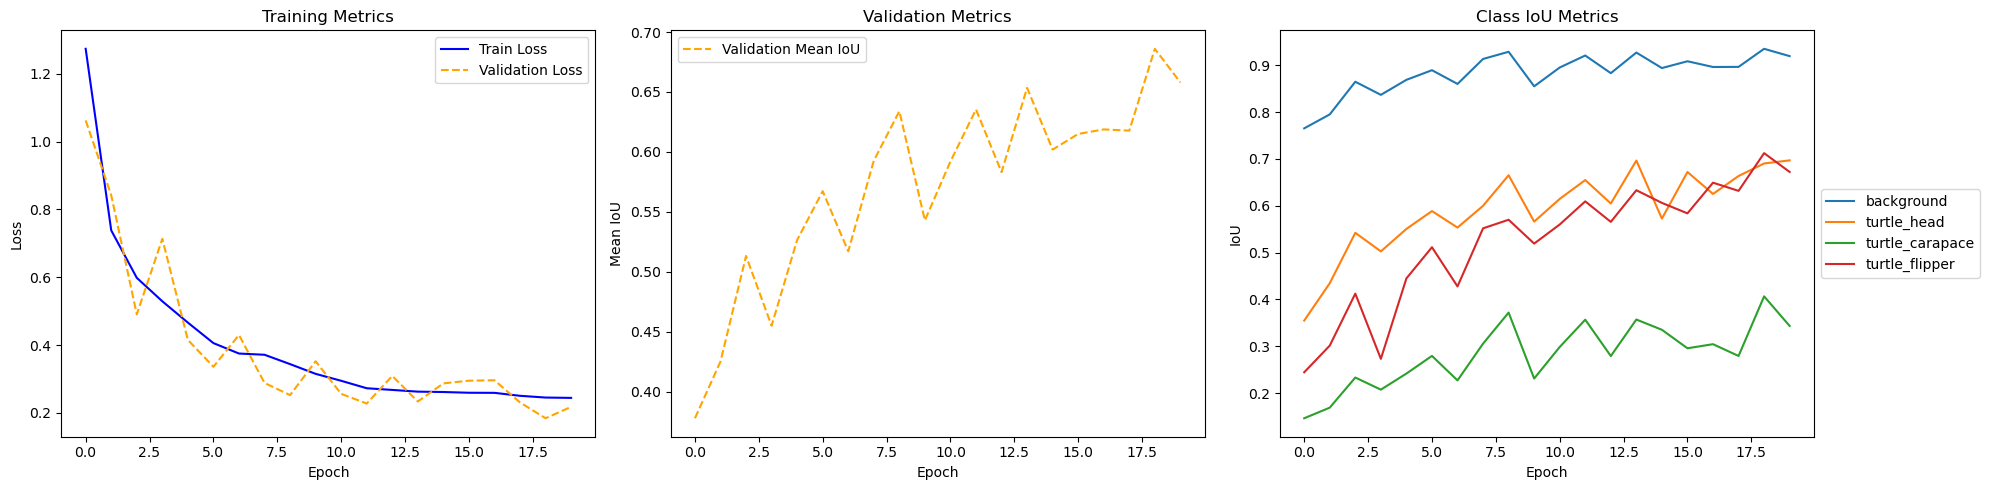


Loading best model for testing...

Evaluating on test set...


C:\Users\cando\AppData\Local\Temp\ipykernel_96084\3723756240.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pth')



Test Results:
Test Mean IoU: 0.7069

Per-class IoU:
background: 0.9477
turtle_head: 0.7632
turtle_carapace: 0.4331
turtle_flipper: 0.6838

Generating final visualizations...

Visualizing test set results...


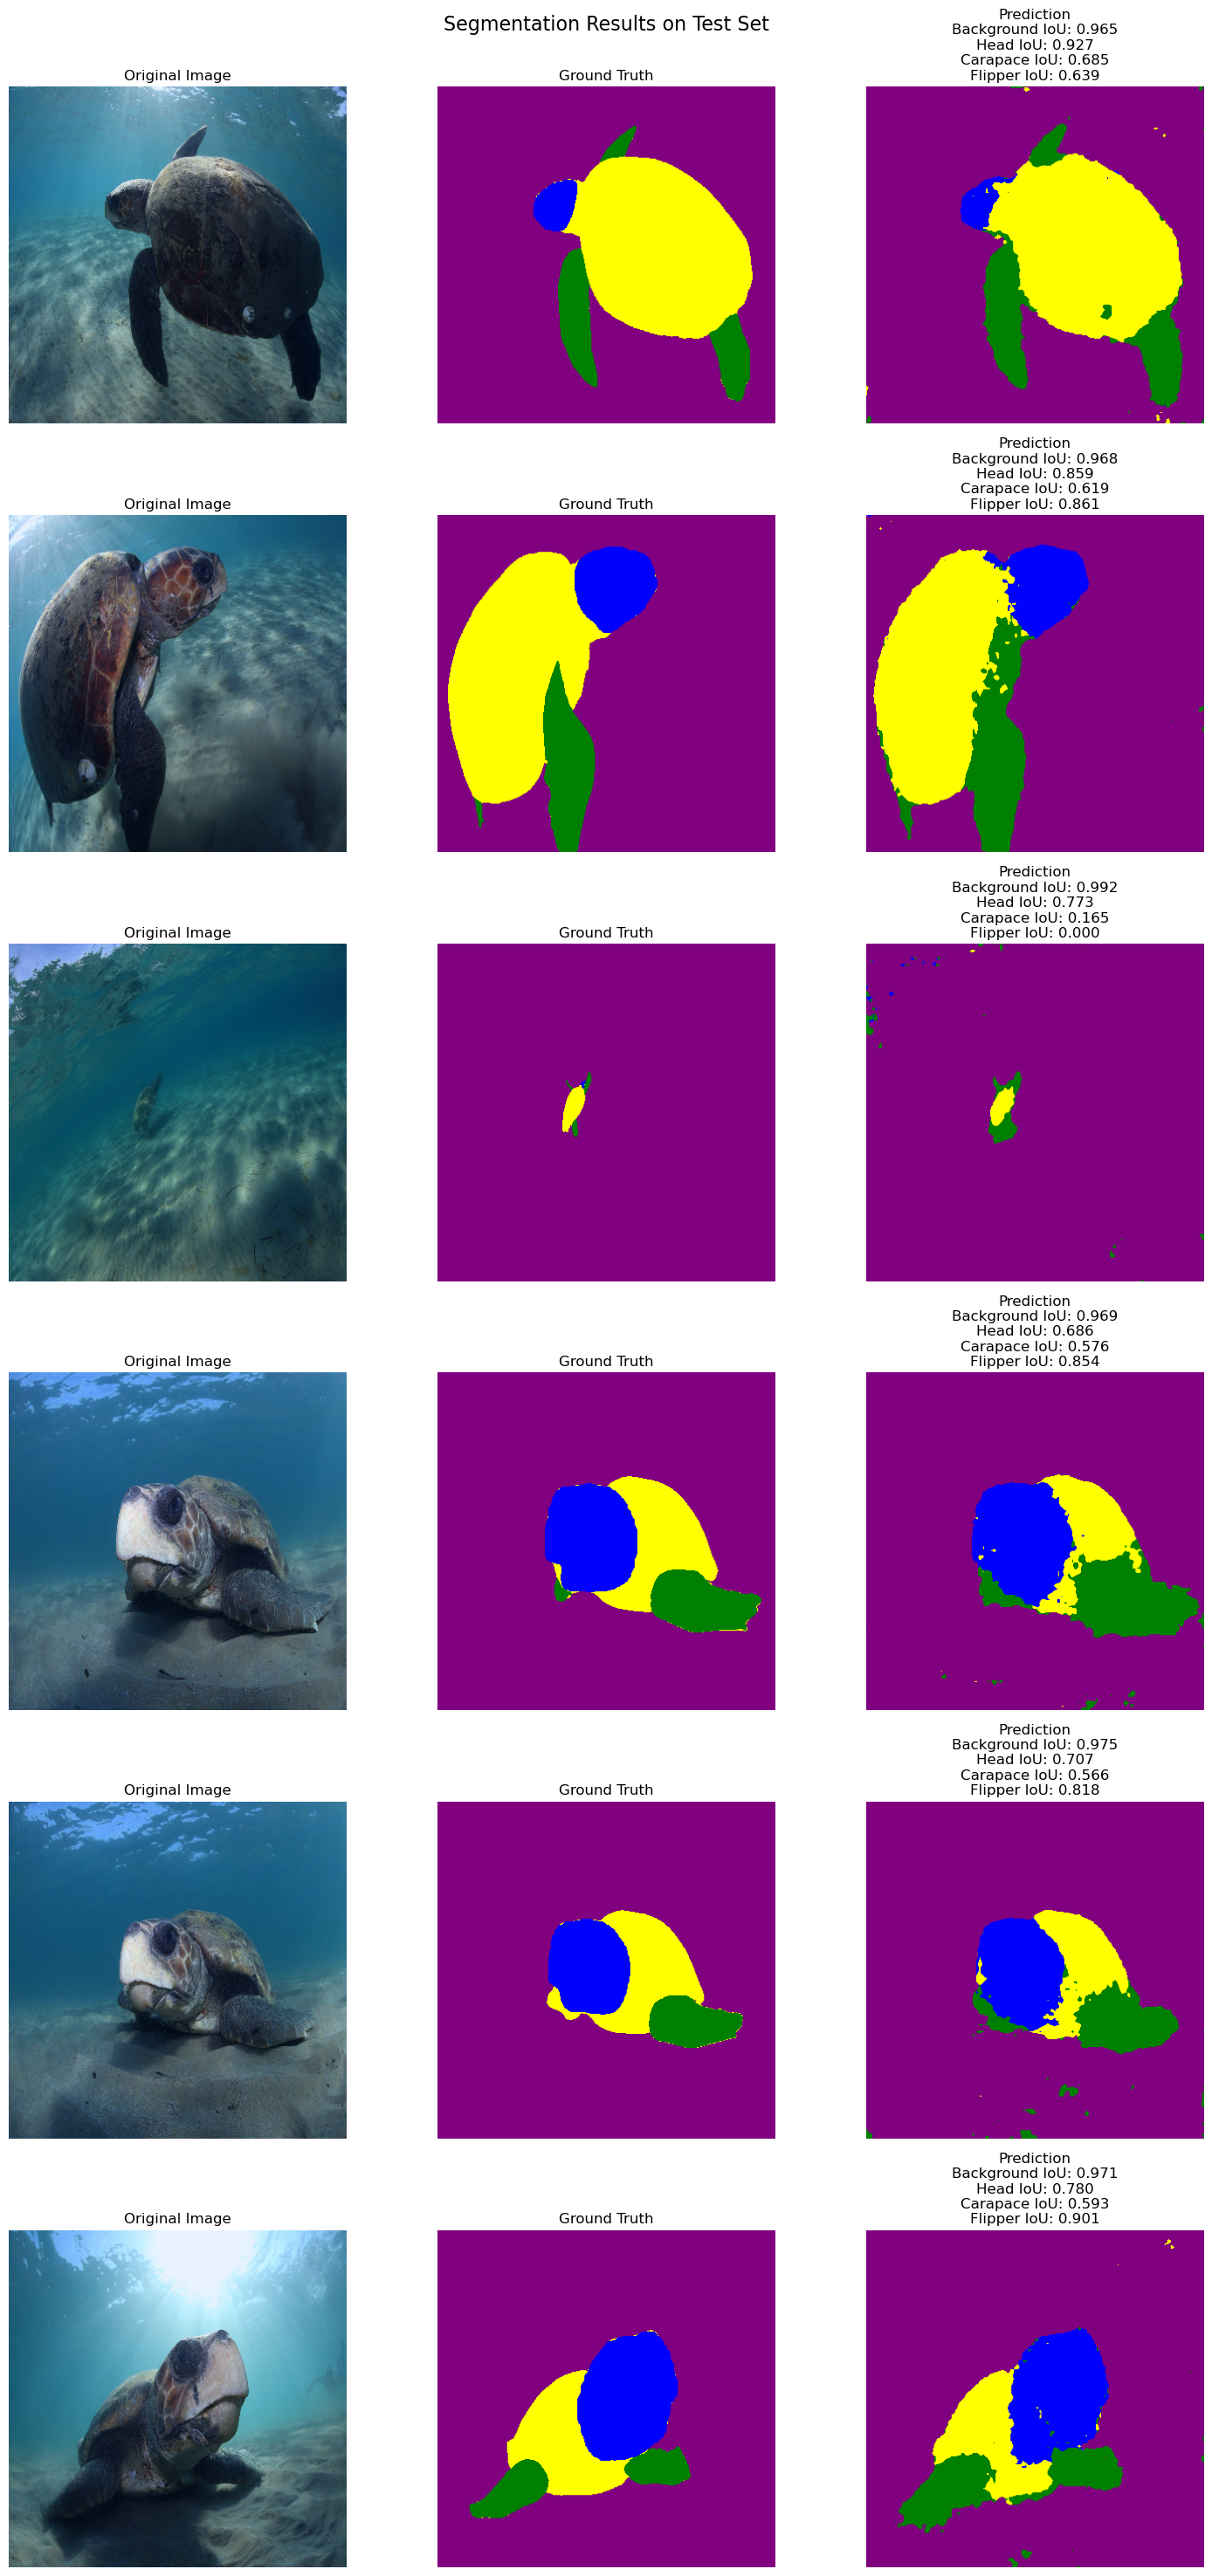


Per-image Segmentation Metrics:
   Background IoU  Head IoU  Carapace IoU  Flipper IoU  Mean IoU
0           0.965     0.927         0.685        0.639     0.804
1           0.968     0.859         0.619        0.861     0.827
2           0.992     0.773         0.165        0.000     0.482
3           0.969     0.686         0.576        0.854     0.771
4           0.975     0.707         0.566        0.818     0.767
5           0.971     0.780         0.593        0.901     0.811

Average Metrics:
Background IoU    0.973
Head IoU          0.789
Carapace IoU      0.534
Flipper IoU       0.679
Mean IoU          0.744
dtype: float64


In [14]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)

# Load best model for testing
print("\nLoading best model for testing...")
checkpoint = torch.load('checkpoints/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Test evaluation
print("\nEvaluating on test set...")
test_metrics = evaluate_model(model, test_loader, criterion, device=device)  # Pass device

print("\nTest Results:")
print(f"Test Mean IoU: {test_metrics['mean_iou']:.4f}")
print("\nPer-class IoU:")
for i in range(NUM_CLASSES):
    print(f"{VOC_CLASSES[i]}: {test_metrics['class_iou'][i]:.4f}")

# Generate final visualizations
print("\nGenerating final visualizations...")
visualize_predictions(
    model,
    test_loader,
    num_samples=6,
    save_path='results/final_predictions.png',
    device=device  # Pass device
)

print("\nVisualizing test set results...")
metrics_df = visualize_sample_predictions(model, test_loader, device=device)  # Pass device


Visualizing the best and the worst in the test set results...


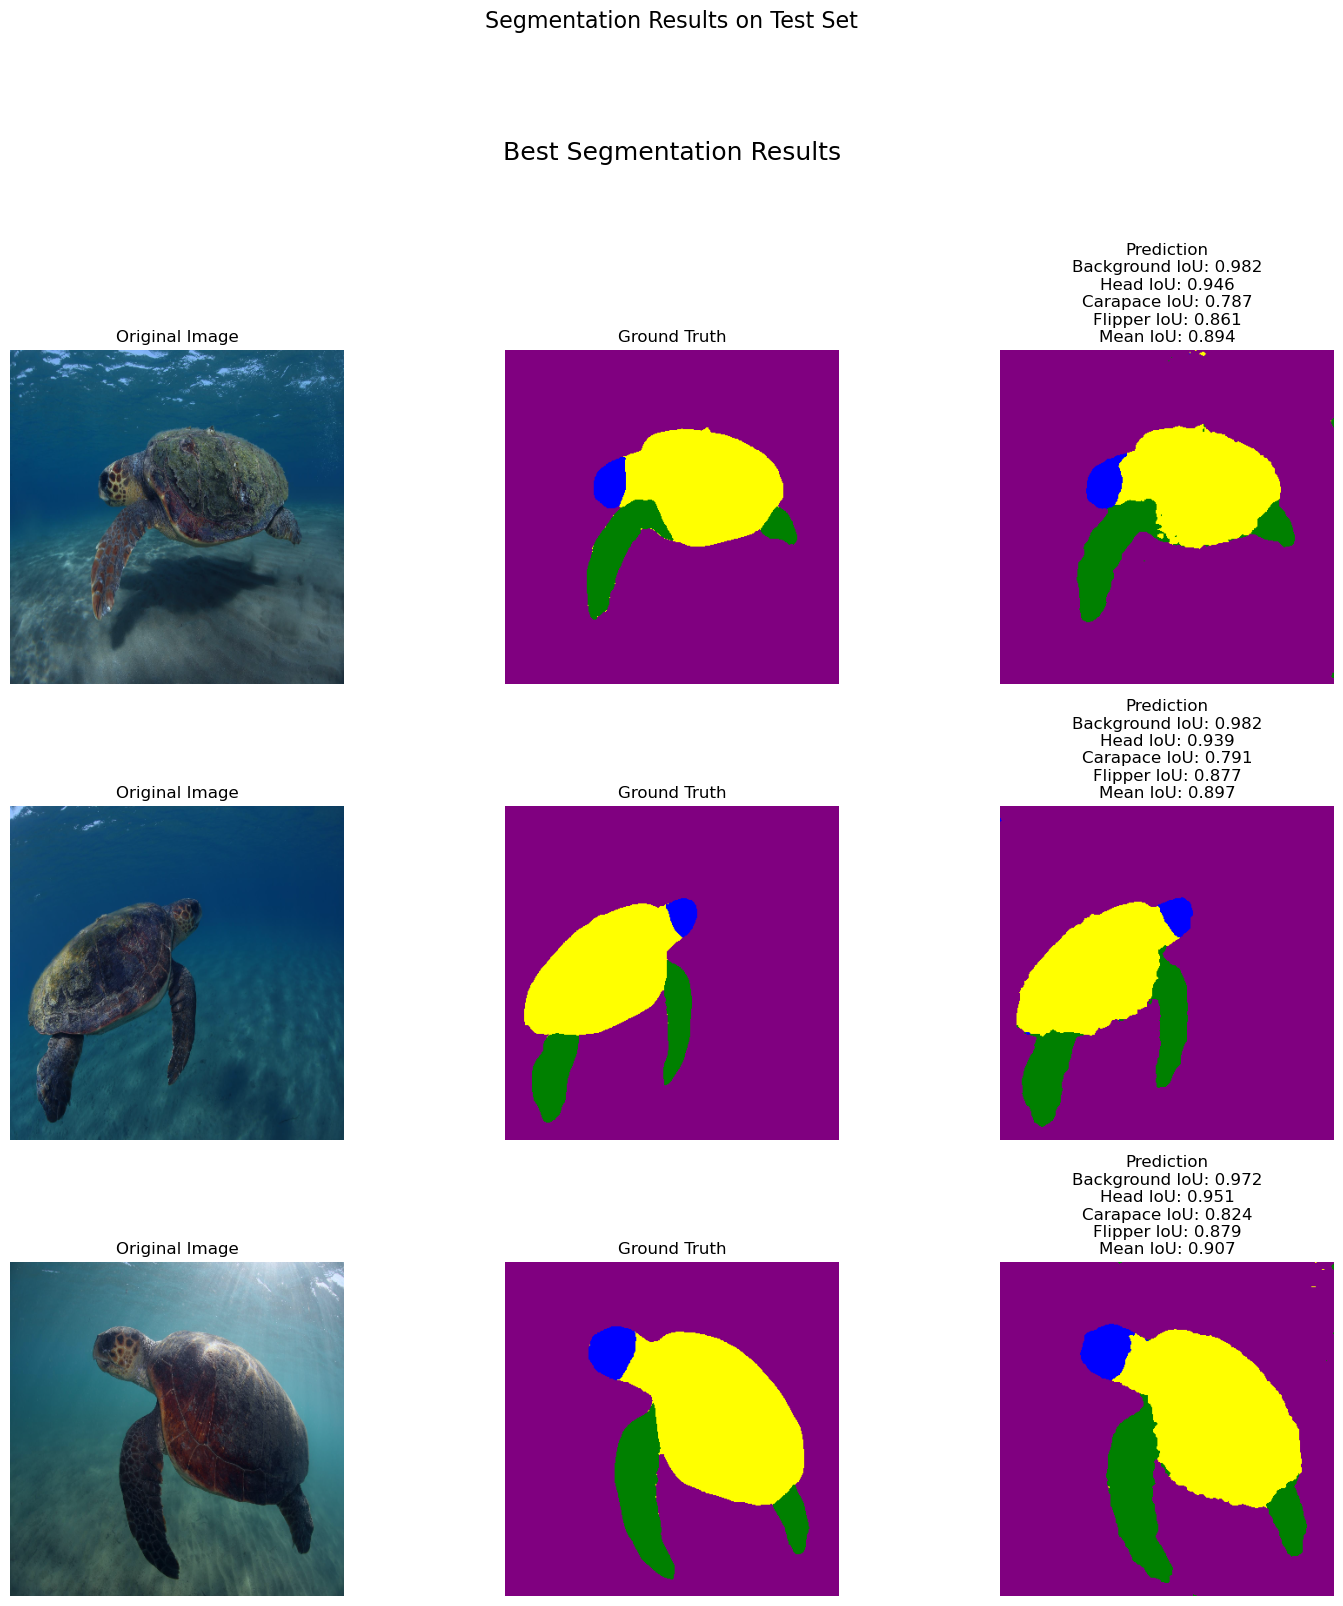

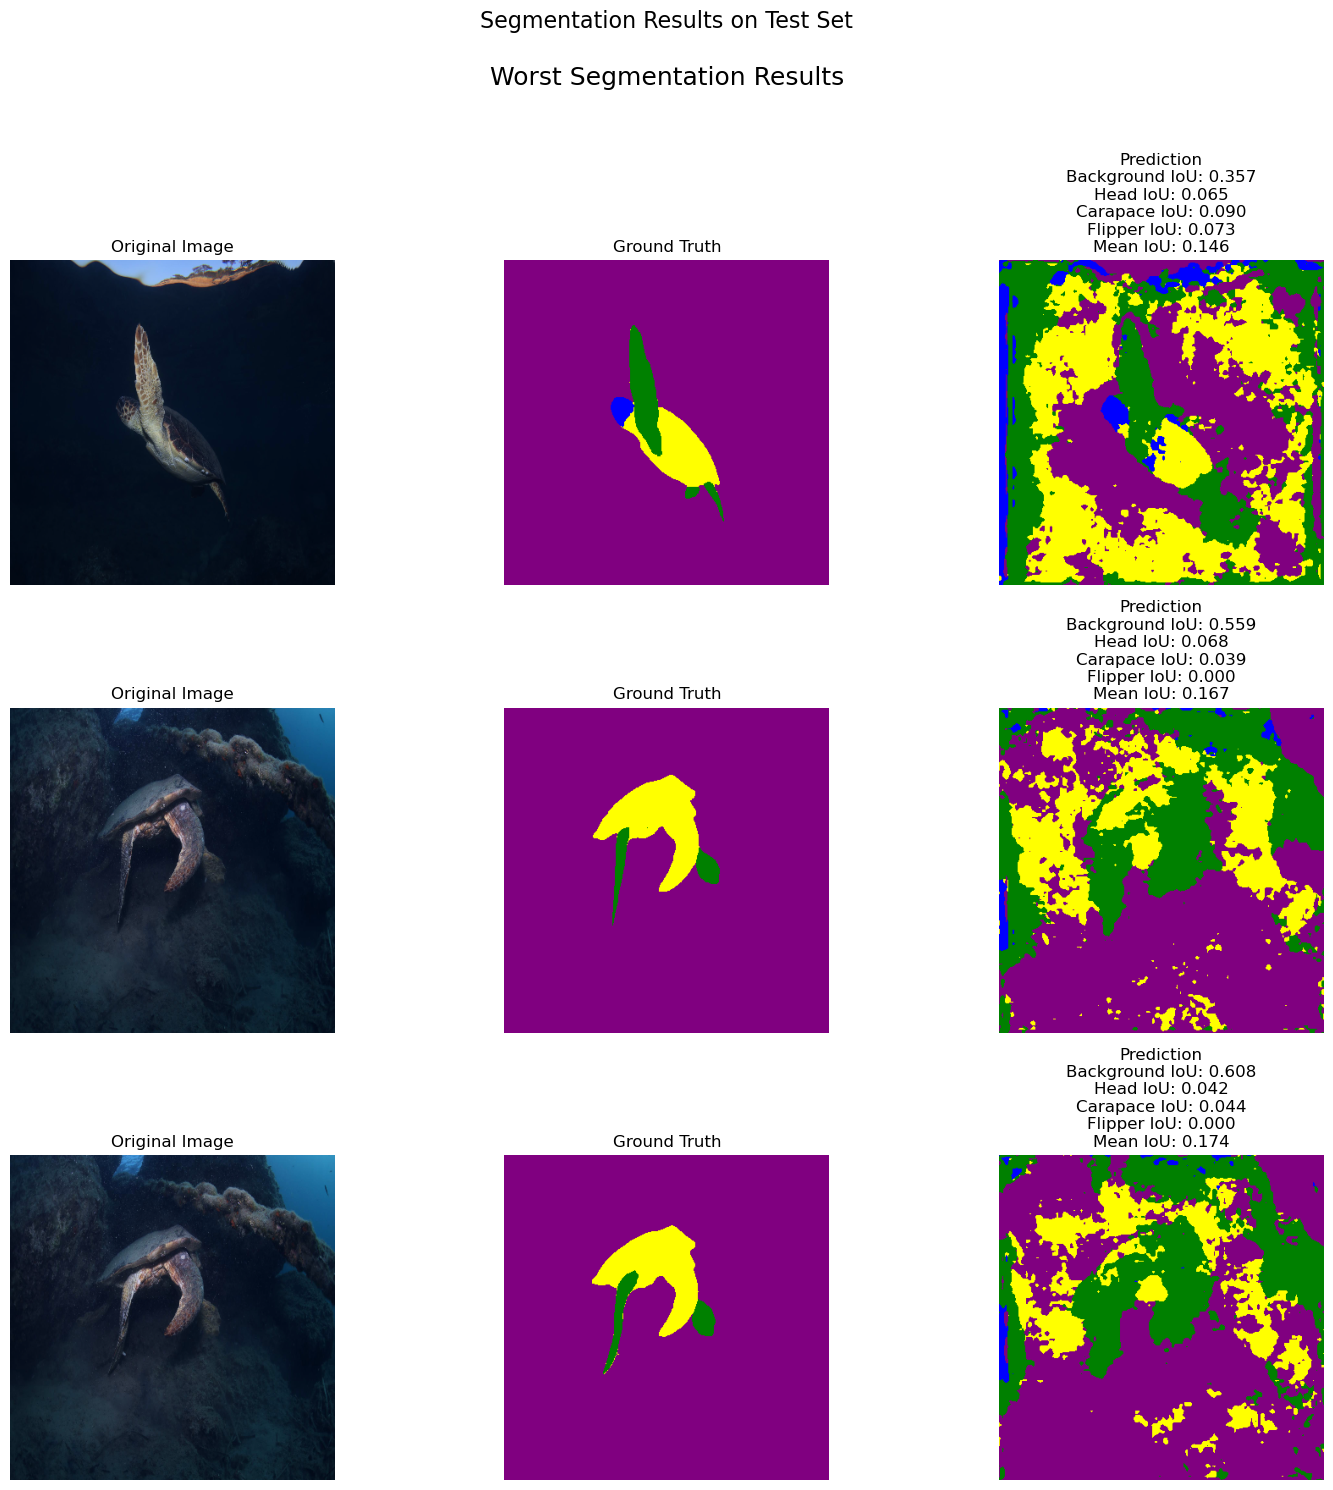


Training and evaluation completed successfully!


In [17]:
print("\nVisualizing the best and the worst in the test set results...")
visualize_best_predictions(model, test_loader, device=device)
visualize_worst_predictions(model, test_loader, device=device)
print("\nTraining and evaluation completed successfully!")